In [20]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re

In [21]:
def E_radiation_MeV(energy_gev, rho):
    return 88.46e-3 * energy_gev**4 / rho

def gamma(ke, m):
    return (ke + m) / m

In [22]:
def __tfsTypeMap( typeName ):
    """
    Maps the TFS types to Python types (only \"str\",\"np.float64\" and \"np.int64\" up to now).

    Arguments:
      - typeName: type string from TFS file.

    Returns:
       - Correspondent python type.
    """
    if "le" in typeName:
        return np.float64
    elif "s" in typeName:
        return str
    elif "d" in typeName:
        return np.int64
    else:
        return np.float64


#! The line numbers required by pandas are 0-indexed.
#! WARNING: pandas.read_table is deprecated in favor of
#!          pandas.read_csv. There should be no difference in
#!          replacing it, but better check.
#!
def twissToPandas( twissFile ):
    """
    This function exploits the TFS standard described in [SL/CO Note 91-31] in order to
    efficiently read the TFS file and identify the types. For simplicity the only
    \"str\" and \"np.float64\" and \"np.int64\" are used as types.

    Arguments:
      - twissFile: string path to the twiss file

    Returns:
      - (dictGlobal, dfRing): where `dictGlobal` is a Python dictionary
                              containing the header of the file, while `dfRing` is a
                              pandas DataFrame containing all the lattice columns.
    """
    colNames = []
    colTypes = []
    headerLength = 0
    rowN, rowStar, rowDoll = (0,0,0)

    with open( twissFile, "r" ) as inputTFS:
        for lin in inputTFS:
            if lin[0] == "@":
                headerLength += 1
            elif lin[0] == "*":
                colNames = re.split('[\s"]+',lin.strip(' \t\n\r\f\v"'))[1:]
                rowStar = rowN
            elif lin[0] == "$":
                colTypes = re.split('[\s"]+',lin.strip(' \t\n\r\f\v"'))[1:]
                rowDoll = rowN
                break
            rowN += 1

    dictColTypes = { name: __tfsTypeMap( typ ) for (name,typ) in zip(colNames,colTypes) }

    dfGlobal = pd.read_table( twissFile, sep='\s+', engine="c", names=["USELESS","INDEX","TYPES","VALUE"], usecols=["INDEX","TYPES","VALUE"], index_col=0, squeeze=True, nrows=headerLength )
    dictGlobal = { name: __tfsTypeMap(typ)( val ) for name,typ,val in zip(dfGlobal.index,dfGlobal["TYPES"],dfGlobal["VALUE"]) }
    dfRing = pd.read_table( twissFile, sep='\s+', engine="c", names=colNames, dtype=dictColTypes, index_col=None, skipinitialspace=True, comment='@', skiprows=[rowStar,rowDoll] )
    return dictGlobal, dfRing

In [23]:
# Machine parameters

rho = 3.3356 * 450 / 2
circum = 6900
e_min = 3.5 # GeV
e_max = 18 # GeV
t_acc = 0.2 # s
t_inject = 0.8 # s
t_extract = 10 # s
n_electrons = 1e11
dpp0 = 1e-3
gamma_tr = 23.27658075
qx = 26.667
dqx = 26
twiss_dict, twiss_df = twissToPandas('./twiss_sps_protons.tfs')

earray_gev = np.array([e_min, 10, 13, 16, e_max])
earray_gev = np.linspace(e_min, e_max, 1000)
brho = 3.3357 * earray_gev  # E~p

# Constants

c = 2.99792458e8 # m/s\n",
eps0 = 8.854187e-12 # F/m\n",
me = 9.10938e-31 # kg\n",
mp = 1.6726e-27 # kg\n",
e = 1.602176e-19 # C\n",
re = 2.8179403e-15 # m \n",
hbar = 1.054571e-34 # Js\n",
me_gev = me / e * 1e-9 * c**2 # GeV/c^2\n",
mp_gev = mp / e * 1e-9 * c**2 # GeV/c^2"

<ipython-input-22-5bec31f9f518>:60: FutureWarning: read_table is deprecated, use read_csv instead.
  dfGlobal = pd.read_table( twissFile, sep='\s+', engine="c", names=["USELESS","INDEX","TYPES","VALUE"], usecols=["INDEX","TYPES","VALUE"], index_col=0, squeeze=True, nrows=headerLength )
<ipython-input-22-5bec31f9f518>:62: FutureWarning: read_table is deprecated, use read_csv instead.
  dfRing = pd.read_table( twissFile, sep='\s+', engine="c", names=colNames, dtype=dictColTypes, index_col=None, skipinitialspace=True, comment='@', skiprows=[rowStar,rowDoll] )


In [24]:
# get the indeces closest to 16 geV and 18 geV

idx_16 = np.argmin(np.abs(earray_gev - 16))
idx_18 = np.argmin(np.abs(earray_gev - 18))

# Acceleration

Phase slip per turn is 2.050380959576878e-08 pi


Text(0.5, 1.0, 'Variation is 8.20 Hz')

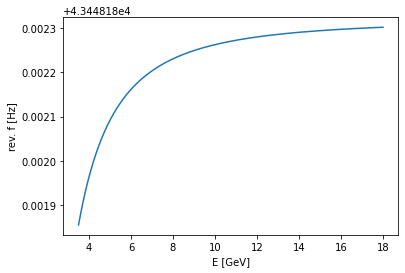

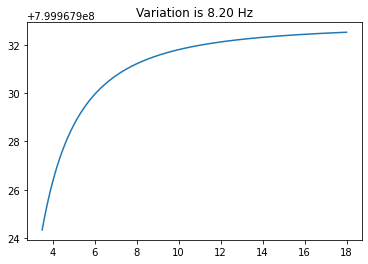

In [25]:
# Revolution frequencies

gamma_r = (earray_gev + me_gev) / me_gev
beta_r = np.sqrt(1 - 1/gamma_r**2)
rev_f = (beta_r * c)/circum
closest_800 = 800e6 - (800e6 % rev_f) 
variation_800 = closest_800.max() - closest_800.min()
phase_slip = 2 * variation_800 / closest_800.min() # [pi] Assuming worst case scenario
print('Phase slip per turn is {} pi'.format(phase_slip))

plt.figure()
plt.plot(earray_gev, rev_f)
plt.xlabel('E [GeV]')
plt.ylabel('rev. f [Hz]')

plt.figure()
plt.plot(earray_gev, closest_800)
plt.title('Variation is {:.2f} Hz'.format(variation_800))

In [26]:
closest_800[0]

799967924.3309587

In [27]:
# Approx total phase slip

total_phase_slip = variation_800.mean()/closest_800.min() * (t_acc+t_inject)*rev_f[-1]; total_phase_slip

0.0004454266285943973

In [28]:
one_turn_time = 1 / rev_f
one_bending_time = 2*np.pi*rho / (beta_r * c)
nturns = t_acc / one_turn_time
v_mv = (e_max - e_min) / nturns *1e3
print('Voltage per turn for acceleration is {} MV'.format(v_mv.mean()))

Voltage per turn for acceleration is 1.6686543896920198 MV


At 18.0 GeV, the radiation energy loss is 12.373155534236718 MeV per turn
At 15.996996996996998 GeV, the radiation energy loss is 7.718702544814708 MeV per turn


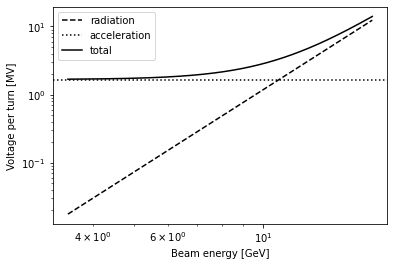

In [29]:
# Needed voltage per turn

radiation_turn = E_radiation_MeV(earray_gev, rho)
v_total = radiation_turn + v_mv
print('At {} GeV, the radiation energy loss is {} MeV per turn'.format(earray_gev[idx_18], radiation_turn[idx_18]))
print('At {} GeV, the radiation energy loss is {} MeV per turn'.format(earray_gev[idx_16], radiation_turn[idx_16]))

plt.figure()
plt.loglog(earray_gev, radiation_turn, linestyle = '--', color = 'black', label = 'radiation')
plt.axhline(v_mv.mean(), label = 'acceleration', linestyle = 'dotted', color = 'black')
plt.loglog(earray_gev, v_total, label = 'total', color = 'black')
plt.ylabel('Voltage per turn [MV]')
plt.xlabel('Beam energy [GeV]')
plt.legend()

At 18.0 GeV, the radiation energy loss is 12.373155534236718 MeV per turn
At 15.996996996996998 GeV, the radiation energy loss is 7.718702544814708 MeV per turn


Text(0.5, 0, 'Beam energy [GeV]')

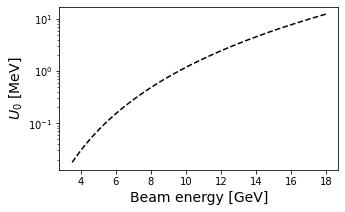

In [30]:
# Needed voltage per turn

radiation_turn = E_radiation_MeV(earray_gev, rho)
v_total = radiation_turn + v_mv
print('At {} GeV, the radiation energy loss is {} MeV per turn'.format(earray_gev[idx_18], radiation_turn[idx_18]))
print('At {} GeV, the radiation energy loss is {} MeV per turn'.format(earray_gev[idx_16], radiation_turn[idx_16]))

plt.figure(figsize=(5, 3))
plt.plot(earray_gev, radiation_turn, linestyle = '--', color = 'black', label = 'radiation')
#plt.axhline(v_mv.mean(), label = 'acceleration', linestyle = 'dotted', color = 'black')
#plt.plot(earray_gev, v_total, label = 'total', color = 'black')
plt.yscale('log')
plt.ylabel(r'$U_0$ [MeV]', fontsize=14)
plt.xlabel('Beam energy [GeV]', fontsize=14)
#plt.legend()

# Radiation Damping

Useful formulas:

$\overline{D} = \frac{\int D/\rho (1/\rho^2 + 2k)ds}{\int 1/\rho^2 ds} \approx <D> / \rho$

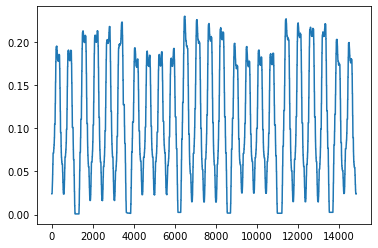

In [31]:
# Calculation of radiation integrals

twiss_df['GAMMAX'] = (1 + twiss_df['ALFX']**2) / twiss_df['BETX']
twiss_df['HX'] = (twiss_df['GAMMAX']*twiss_df['DX']**2 +
                  2*twiss_df['ALFX']*twiss_df['DX']*twiss_df['DPX'] + 
                  twiss_df['BETX']*twiss_df['DPX']**2)

twiss_bends = twiss_df[twiss_df["NAME"].str.contains("MBA")==True]

plt.figure()
plt.plot(twiss_df['HX'])

In [32]:
# Lattice parameters

mean_dispersion = twiss_bends['DX'].mean()
bend_circum = 2 * np.pi * rho

int1 = bend_circum * mean_dispersion / rho
int2 = bend_circum / rho**2
int3 = bend_circum / rho**3
int4 = bend_circum * mean_dispersion / rho**3
int5 = twiss_bends.HX.mean() * bend_circum / rho**3

dbar = int4 / int2
jx = 1 - int4 / int2
jy = 1
je = 2 + int4 / int2

In [33]:
### The other power loss formula

power_1e_other = e**2/6/np.pi/eps0/c**7/me**4 * (earray_gev*1e9*e)**4/rho**2

Text(0.5, 0, 'Beam energy [GeV]')

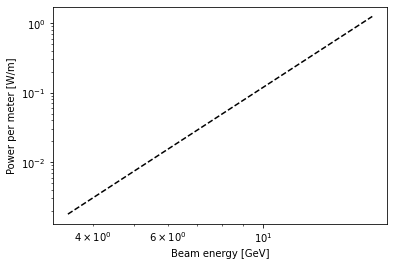

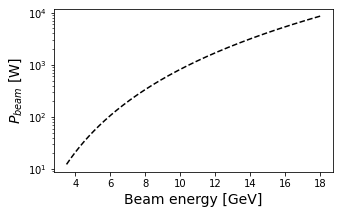

In [34]:
### Beam radiated power 

power_1e_inst = radiation_turn * 1e6 * e / one_bending_time # Instantaneous
power_1e = radiation_turn * 1e6 * e / one_turn_time # Mean 
power_beam = n_electrons * power_1e
power_per_meter = power_beam / circum


plt.figure()
plt.loglog(earray_gev, power_per_meter, linestyle = '--', color = 'black')
plt.ylabel('Power per meter [W/m]')
plt.xlabel('Beam energy [GeV]')

plt.figure(figsize=(5,3))
plt.plot(earray_gev, power_beam, linestyle = '--', color = 'black')
plt.yscale('log')
plt.ylabel(r'$P_{beam}$ [W]', fontsize=14)
plt.xlabel('Beam energy [GeV]', fontsize=14)

Text(0, 0.5, 'Critical omega [rad/s]')

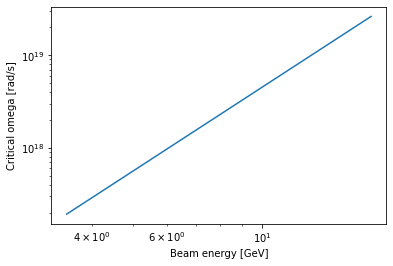

In [35]:
# Critical photon + photon quantities

omega_crit = 3 * c * gamma_r**3 / (2*rho)
u_crit = hbar * omega_crit
N_gamma = 15 * np.sqrt(3) / 8 * power_1e / u_crit  # photon number per second
u_mean = 8 / 15 / np.sqrt(3) * u_crit
u2_mean = 11 / 27 * u_crit**2

u_mean_gev = u_mean / e * 1e-9
u2_mean_gev = u2_mean / (e)**2 * (1e-9)**2

plt.figure()
plt.loglog(earray_gev, omega_crit)
plt.xlabel('Beam energy [GeV]')
plt.ylabel('Critical omega [rad/s]')

Important to remember that injection time is 0.8s, but this is still short compared to the damping times at injection energy. See plot below.

Damping time at 18.0 GeV is 0.033430051687939076 s
Damping time at 15.996996996996998 GeV is 0.04762545892263179 s


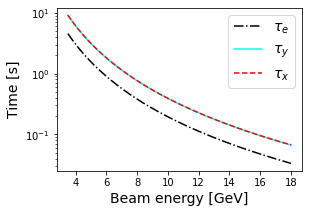

In [36]:
# Calculating longitudinal emittance and damping times
# For transverse they are twice these values

e_damp_time = 2 * earray_gev * 1e3 * one_turn_time / (je * radiation_turn)
x_damp_time = 2 * earray_gev * 1e3 * one_turn_time / (jx * radiation_turn)
y_damp_time = 2 * earray_gev * 1e3 * one_turn_time / (jy * radiation_turn)

plt.figure(figsize=(4.4, 3))
plt.plot(earray_gev, e_damp_time, label=r'$\tau_e$', color='black', linestyle='-.')
plt.plot(earray_gev, y_damp_time, label=r'$\tau_y$', color='cyan', linewidth=1.5)
plt.plot(earray_gev, x_damp_time, label=r'$\tau_x$', color='red', linestyle='dashed')
plt.xlabel('Beam energy [GeV]', fontsize=14)
plt.ylabel('Time [s]', fontsize=14)
plt.yscale('log')
#plt.axhline(t_acc+t_inject, label='injection + acceleration', color='k')
plt.legend(fontsize=14)

print('Damping time at {} GeV is {} s'.format(earray_gev[idx_18], e_damp_time[idx_18]))
print('Damping time at {} GeV is {} s'.format(earray_gev[idx_16], e_damp_time[idx_16]))

Text(0.5, 0, 'Beam energy [GeV]')

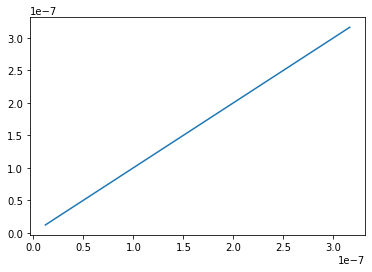

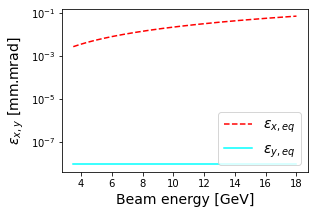

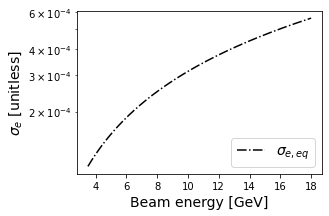

In [37]:
# Equilibrium emittances

# Transverse:

emit_x = 55/32/np.sqrt(3) * hbar/me/c * gamma_r**2 * int5/jx/int2
emit_y = 55/64/np.sqrt(3) * hbar/me/c * twiss_bends['BETY'].mean() * bend_circum / rho**3 /jy/int2
emit_y = emit_y*np.ones(earray_gev.shape)
sigma_e2_other = 55/32/np.sqrt(3) * hbar/me/c * gamma_r**2 * int3/je/int2

# Longitudinal:

dE2 = (1/4) * e_damp_time * N_gamma * u2_mean_gev  # Absolute energy spread squared
sigma_e2 = dE2 / earray_gev**2  # Relative energy spread squared
sigma_e = np.sqrt(sigma_e2)

plt.figure()
plt.plot(sigma_e2_other, sigma_e2)

# Plot equilibrium energy spread as function of energy

# plt.figure()

# plt.plot(earray_gev, sigma_e, color = 'red',
#          label=r'$\sigma_{e, equilibrium}$')
# plt.plot(earray_gev, 3*sigma_e, color = 'red', linestyle = 'dashed',
#          label=r'$3 \sigma_{e, equilibrium}$')
# plt.ylabel('dE/E')
# plt.xlabel('energy [GeV]')
# plt.axhline(dpp0, label=r'$\sigma_{e, 0}$', color='k')
# plt.legend()

# plt.figure()

# plt.plot(earray_gev, emit_x, color = 'red',
#          label=r'$\epsilon_{x, equilibrium}$')
# plt.plot(earray_gev, 9*emit_x, color = 'red', linestyle = 'dashed',
#          label=r'$9 \epsilon_{x, equilibrium}$')
# plt.ylabel('m.rad')
# plt.xlabel('energy [GeV]')
# #plt.axhline(dpp0, label=r'$\sigma_{e, 0}$', color='k')
# plt.legend()

# plt.figure()

# plt.plot(earray_gev, emit_y, color = 'red',
#          label=r'$\epsilon_{y, equilibrium}$')
# plt.plot(earray_gev, 9*emit_y, color = 'red', linestyle = 'dashed',
#          label=r'$9 \epsilon_{y, equilibrium}$')
# plt.ylabel('m.rad')
# plt.xlabel('energy [GeV]')
# #plt.axhline(dpp0, label=r'$\sigma_{e, 0}$', color='k')
# plt.legend()

fig, ax = plt.subplots(figsize = (4.4, 3))
ax.plot(earray_gev, emit_x*1e6, label=r'$\epsilon_{x,eq}$', color='red', linestyle='dashed')
ax.plot(earray_gev, emit_y*1e6, label=r'$\epsilon_{y,eq}$', color='cyan')
ax.set_ylabel(r'$\epsilon_{x,y}$ [mm.mrad]', fontsize=14)
ax.set_yscale('log')
ax.legend(fontsize=14, loc='lower right')
ax.set_xlabel('Beam energy [GeV]', fontsize=14)

fig, ax = plt.subplots(figsize = (4.4, 3))
ax.plot(earray_gev, sigma_e, label=r'$\sigma_{e,eq}$', color='black', linestyle='-.')
ax.set_ylabel(r'$\sigma_e$ [unitless]', fontsize=14)
ax.set_yscale('log')
ax.legend(fontsize=14, loc='lower right')
ax.set_xlabel('Beam energy [GeV]', fontsize=14)

In [38]:
# Calculate emittance as a function of time (basic exponential decay) 

def time_varying_exp(tau_array, neq_array, n0, dt):
    
    sol = [n0]
    ts = [0]
    for tau, neq in zip(tau_array, neq_array):
        n_temp = sol[-1] - tau * (sol[-1] - neq) * dt
        tn_temp = ts[-1] + dt
        
        sol.append(n_temp)
        ts.append(tn_temp)
    return sol, ts
    

In [39]:
# Extend sigma_e and damp times to include injection and flattop

dt = t_acc/len(earray_gev)
injection_steps = int(t_inject/dt)
extraction_steps = int((t_extract)/dt)

eramp_gev = earray_gev.tolist()
einject_gev = [eramp_gev[0]]*injection_steps
eextract_gev = [eramp_gev[-1]]*extraction_steps
etotal_gev = einject_gev + eramp_gev + eextract_gev 

e_damp_total = [e_damp_time.tolist()[0]]*injection_steps + e_damp_time.tolist() + [e_damp_time.tolist()[-1]]*extraction_steps
sigma_e_total = [sigma_e.tolist()[0]]*injection_steps + sigma_e.tolist() + [sigma_e.tolist()[-1]]*extraction_steps

In [40]:
# Energy spread as function of time

sigma_e_diff, t_diff = time_varying_exp(e_damp_total, sigma_e_total, dpp0, dt)

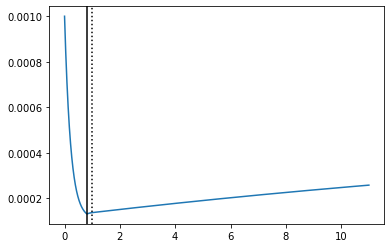

In [41]:
plt.figure()
plt.plot(t_diff, sigma_e_diff)
plt.axvline(t_inject, color='k', label='end injection')
plt.axvline(t_inject+t_acc, color='k', linestyle='dotted', label='end of ramp')

Text(0.5, 0, 'Bucket height in # of $\\sigma$')

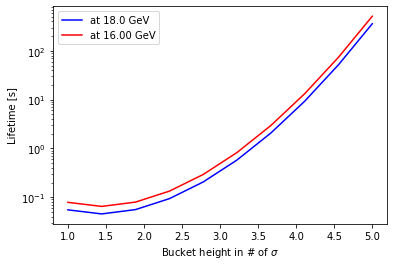

In [42]:
# Quantum lifetime

def quantum_lifetime(damp_time, nsigma):
    e_zeta = 1/2 * nsigma **2
    quantum_time = damp_time/2 * np.exp(e_zeta) / e_zeta
    return quantum_time


bucket_nsigma_array = np.linspace(1, 5, 10)
e_quantum_time_18 = quantum_lifetime(e_damp_time[idx_18], bucket_nsigma_array)
e_quantum_time_16 = quantum_lifetime(e_damp_time[idx_16], bucket_nsigma_array)

plt.figure()
plt.plot(bucket_nsigma_array, e_quantum_time_18, label='at {} GeV'.format(earray_gev[idx_18]), color='blue')
plt.plot(bucket_nsigma_array, e_quantum_time_16, label='at {:.2f} GeV'.format(earray_gev[idx_16]), color='red')
plt.yscale('log')
plt.legend()
plt.ylabel('Lifetime [s]')
plt.xlabel(r'Bucket height in # of $\sigma$')

In [43]:
def bucket_height(v_lost_mv, v_in_mv, harmonic, eta, energy_mev ,beta_r=1):
    phi_s = np.arcsin(v_lost_mv/v_in_mv)
    phase_factor = 2 * np.cos(phi_s) + (2 * phi_s - np.pi) * np.sin(phi_s)
    dE_e2_bucket = (v_in_mv*beta_r**2 / (np.pi*harmonic*
                                                eta*energy_mev) * phase_factor)
    return np.sqrt(dE_e2_bucket)

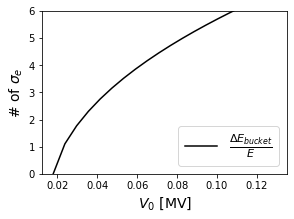

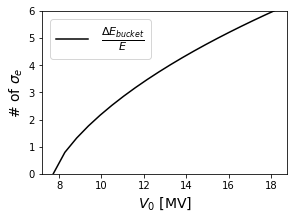

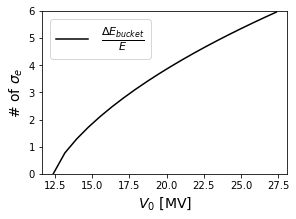

In [50]:
## Bucket height as a function of bucket voltage

 # MV
harmonic = np.round(closest_800 / rev_f)
eta = (1/gamma_tr**2 - 1/gamma_r**2)

for idx in [1, idx_16, idx_18]:
    extra_v_array = np.linspace(0, 15, 20)/gamma_r[-1]**3 * gamma_r[idx]**3
    dE_e_bucket_18 = bucket_height(radiation_turn[idx], radiation_turn[idx] + extra_v_array,
                                   harmonic[idx], eta[idx], earray_gev[idx]*1e3)

    plt.figure(figsize=(4.4,3))
    plt.plot(radiation_turn[idx] +extra_v_array, dE_e_bucket_18/sigma_e[idx],
             color='k', label = r'$\frac{\Delta E_{bucket}}{E}$')
    plt.xlabel('$V_0$ [MV]', fontsize=14)
    plt.ylabel(r'# of $\sigma_e$', fontsize=14)
    plt.legend(fontsize=16)
    #plt.axhline(3, color='grey', linestyle='dotted')
    plt.ylim(0, 6)

In [51]:
def synchrotron_omega(v_lost_mv, v_in_mv, harmonic, eta, energy_mev, rev_f ,beta_r=1):
    
    phi_s = np.arcsin(v_lost_mv/v_in_mv)
    synch_ratio = np.sqrt(harmonic*
                         v_in_mv*np.abs(eta*np.cos(phi_s))/(2*np.pi*beta_r**2*energy_mev))
    synch_omega = 2*np.pi*rev_f * synch_ratio
    return synch_omega

def bunch_time(sigma_e, v_lost_mv, v_in_mv, harmonic, eta, energy_mev, rev_f ,beta_r=1, n_points=100):
    phi_s = np.arcsin(v_lost_mv/v_in_mv)
    phi_s = np.pi - phi_s

    # Solve numerically the synchrotron hamiltonian
    
    H_tot = 0.5*harmonic*2*np.pi*rev_f*eta*sigma_e**2
    
    phi_left = np.linspace(-np.pi, phi_s, n_points)
    phi_right = np.linspace(phi_s, np.pi, n_points)
    
    left_0 = (H_tot - 2*np.pi*rev_f*v_in_mv/(2*np.pi*beta_r**2*energy_mev)*(np.cos(phi_left)-np.cos(phi_s) + (phi_left-phi_s)*np.sin(phi_s)))
    
    right_0 = (H_tot - 2*np.pi*rev_f*v_in_mv/(2*np.pi*beta_r**2*energy_mev)*(np.cos(phi_right)-np.cos(phi_s) + (phi_right-phi_s)*np.sin(phi_s)))
    
    plt.figure()
    plt.plot(left_0)
    plt.plot(right_0)
    
    phi_left_min = phi_left[np.argmin(np.abs(left_0))]
    phi_right_min = phi_right[np.argmin(np.abs(right_0))]
    
    phi_spread = np.abs(phi_right_min - phi_left_min)/2
    sigma_t = phi_spread/(harmonic*2*np.pi*rev_f)
    
    return sigma_t
    

def touschek_lifetime(sigma_e, emit_x, emit_y, bucket_height, twiss_df, synch_omega, eta, gamma_r, beta_r=1):
        
    sigma_t = eta/synch_omega * sigma_e
    sigma_s = beta_r * c * sigma_t
    print(sigma_s)
    sigma_x = np.sqrt(twiss_df['BETX'].mean()*emit_x + sigma_e**2 * twiss_df['DX'].mean()**2)
    sigma_y = np.sqrt(twiss_df['BETY'].mean()*emit_y + sigma_e**2 * twiss_df['DY'].mean()**2)
    
    print(sigma_t)
    print(sigma_s)

    t_tous = (48*gamma_r**2 *np.pi* sigma_x * sigma_y * sigma_s *
              bucket_height**3 /(n_electrons*re**2*c))
    
    return t_tous

[0.02267223 0.02086262 0.01952956 0.01848139 0.01762181 0.01689587
 0.01626939 0.01571967 0.01523095 0.01479181 0.01439373 0.01403019
 0.0136961  0.01338741 0.01310081 0.01283363 0.01258361 0.0123489
 0.01212788 0.01191921]
[7.56264076e-11 6.95901964e-11 6.51435973e-11 6.16472899e-11
 5.87800394e-11 5.63585719e-11 5.42688307e-11 5.24351828e-11
 5.08049834e-11 4.93401579e-11 4.80123024e-11 4.67996776e-11
 4.56852826e-11 4.46555766e-11 4.36996024e-11 4.28083713e-11
 4.19744196e-11 4.11914832e-11 4.04542550e-11 3.97581999e-11]
[0.02267223 0.02086262 0.01952956 0.01848139 0.01762181 0.01689587
 0.01626939 0.01571967 0.01523095 0.01479181 0.01439373 0.01403019
 0.0136961  0.01338741 0.01310081 0.01283363 0.01258361 0.0123489
 0.01212788 0.01191921]
[0.0243163  0.02244958 0.0210805  0.02000748 0.01912957 0.01838932
 0.01775111 0.01719139 0.01669382 0.01624664 0.01584107 0.01547045
 0.01512954 0.01481423 0.01452117 0.01424761 0.01399131 0.01375036
 0.01352316 0.01330834]
[8.11104358e-11 7.488

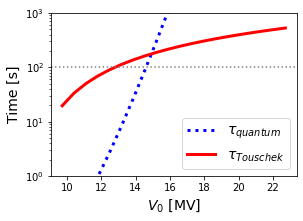

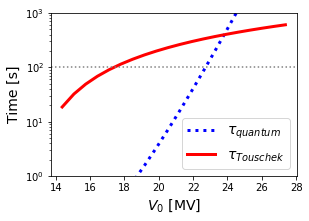

In [52]:
# Lifetimes for different energies

%matplotlib inline

extra_v_array = np.linspace(2, 15, 20) # MV
harmonic = np.round(closest_800 / rev_f)
eta = (1/gamma_tr**2 - 1/gamma_r**2)

for idx in [idx_16, idx_18]:
    dE_e_bucket = bucket_height(radiation_turn[idx], radiation_turn[idx] + extra_v_array,
                               harmonic[idx], eta[idx], earray_gev[idx]*1e3)
    
    synch_omega = synchrotron_omega(radiation_turn[idx], radiation_turn[idx] + extra_v_array,
                                   harmonic[idx], eta[idx], earray_gev[idx]*1e3, rev_f[idx])


    t_tous = touschek_lifetime(sigma_e[idx], emit_x[idx], emit_y[idx],
                                   dE_e_bucket, twiss_df, synch_omega, eta[idx],
                                  gamma_r[idx], beta_r=1)

    t_quantum = quantum_lifetime(e_damp_time[idx], dE_e_bucket/sigma_e[idx])
    
    t_small_quantum = t_quantum * (t_quantum<=t_tous)
    t_small_tous = t_tous * (t_tous<t_quantum)
    
    plt.figure(figsize=(4.4, 3))
    #plt.title('Beam energy={:.2f} GeV'.format(earray_gev[idx]))
    plt.plot(radiation_turn[idx]+extra_v_array, t_quantum, label=r'$\tau_{quantum}$',
             color='blue', linestyle='dotted', linewidth=3)
    plt.plot(radiation_turn[idx]+extra_v_array, t_tous, label=r'$\tau_{Touschek}$',
             color='red', linestyle='solid', linewidth=3)
    plt.yscale('log')
    plt.legend(fontsize=14)
    plt.xlabel('$V_{0}$ [MV]', fontsize=14)
    plt.ylabel('Time [s]', fontsize=14)
    plt.axhline(100, color='grey', linestyle='dotted')
    plt.ylim(1, 1e3)


5.191391325314088e-11 5.169851843285624e-11
5.080693904274174e-11 5.0887753128936384e-11


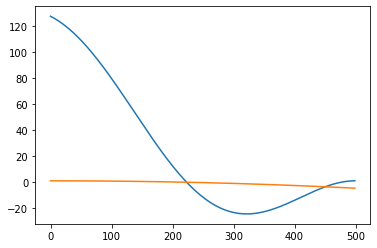

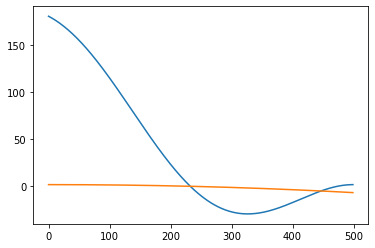

In [53]:
## Time spread for chosen voltages at 16GeV and 18GeV. 
#To check that linear approximation used for touschek lifetime is valid

extra_vs = [7,10]
harmonic = np.round(closest_800 / rev_f)
eta = (1/gamma_tr**2 - 1/gamma_r**2)

for idx, chosen_v in zip([idx_16, idx_18], extra_vs):
    
    sigma_t = bunch_time(sigma_e[idx], radiation_turn[idx],radiation_turn[idx] + chosen_v,
                               harmonic[idx], eta[idx], earray_gev[idx]*1e3, rev_f[idx], n_points=500)
    
    synch_omega = synchrotron_omega(radiation_turn[idx], radiation_turn[idx] + chosen_v,
                                   harmonic[idx], eta[idx], earray_gev[idx]*1e3, rev_f[idx])
    
    sigma_t_approx = eta[idx]/synch_omega * sigma_e[idx]
    
    print(sigma_t_approx, sigma_t)

# very good agreement!

## Switch off times

For a cavity with energy $E_{cav}$, a beam of N particles and a power loss per particle of $P_{rad}$, we define a 'switch off' time of 

$$ \tau_{off} = \frac{E_{cav}}{N P_{rad}} $$

Noting that the stored power in a cavity is

$$ E_{cav} = \alpha V^2$$

we can get $\alpha$ from SuperFish for our particular cavity and compute this for all energies. 

We also have to remember that we have two cavities! So voltages computed in previous sections can be split between them.

Text(0.5, 0, 'Beam energy [GeV]')

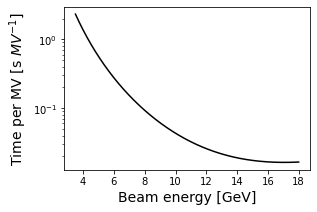

In [54]:
alpha = 41 / (12.9*0.94)**2 # [J/MV^2] From superfish, it's a rough estimate
tfactor = 0.7
ncavities = 2

v_bucket = 10 #/gamma_r[-1]**4 * gamma_r**4 # MV
v_rad = radiation_turn # MV

e_stored = alpha * ((v_bucket+v_rad)/(ncavities*tfactor))**2

p_lost_beam = power_1e * n_electrons/2

t_off = e_stored / p_lost_beam

plt.figure(figsize=(4.4,3))
plt.plot(earray_gev, t_off, color='black')
plt.yscale('log')
plt.ylabel(r'Time per MV [s $MV^{-1}$]', fontsize=14)
plt.xlabel('Beam energy [GeV]', fontsize=14)

# Impedance effects

For proton operation we have a total of 10^14-10^15 particles in the SPS. For HL-LHC this figure is expected to increase by a factor 2.

For electron operation we have a  total of 10^11.

This is 3 to 4 orders of magnitude higher currents (same charge and same revolution frequency).

Installing the 12 LEP normal conducting cavities would increase the ring low-freq impedance ImZ/n by 0.55 ohm, comparable with the TOTAL impedance after LIU upgrades...

Text(0.5, 0, 't [s]')

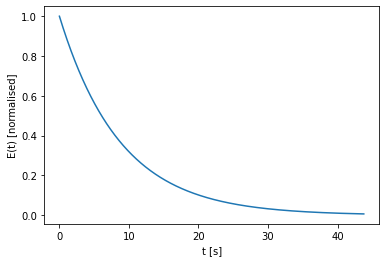

In [55]:
import numpy as np
import matplotlib.pyplot as plt

# Beam loading

e0 = 12.9e6
q0_factor = 2.2e10
omega_cav = 2*np.pi*800e6 # Hz
omega_r = 2*np.pi*800e6 # Hz
t_factor = 0.77
power_diss = 9.5 # W
phi_s = np.pi - np.pi/4
l_cav = 0.94
r_surf = 16e-9  # Surface resistance of cavity in ohm
r_over_q = 419.948 # ohm

inductance_cav = r_over_q * 1/omega_r
capacitance_cav = 1/r_over_q * 1/omega_r

# Machine params approx

one_turn_time = 23e-6 # s
n_electrons = 1e11
e = 1.602176e-19 # electron charge [C]

r_shunt_per_l = 9200825.314e6 # Ohm/m, (v_rf)**2 /2Pd/L
r_shunt = r_shunt_per_l * l_cav


fill_time0 = 2*q0_factor/omega_cav
kr0 = omega_r * r_shunt/ (4*np.pi*q0_factor)

wake_ts = np.linspace(0, 5*fill_time0, 1000)
wakes = 4*np.pi*kr0*np.exp(-wake_ts/fill_time0)
wakes = wakes/wakes.max()

plt.figure()
plt.plot(wake_ts, wakes)
plt.ylabel('E(t) [normalised]', color='black')
plt.xlabel('t [s]')

In [56]:
1/q0_factor*omega_cav

0.2284794657156213

cavity inductance 8.354600005194408e-08
cavity capacitance 4.737340786594274e-13


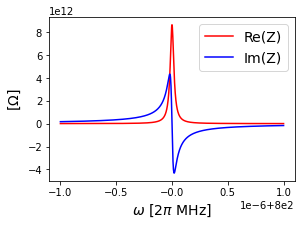

In [57]:
print('cavity inductance {}'.format(inductance_cav))
print('cavity capacitance {}'.format(capacitance_cav))

def impedance_parallel(omega, r, l, c):
    return 1/(1j*omega*c + 1/(1j*omega*l) + 1/r)

omega_array = np.linspace(omega_r - 2*np.pi, omega_r + 2*np.pi, 1000)
impedances = impedance_parallel(omega_array, r_shunt, inductance_cav, capacitance_cav)

plt.figure(figsize=(4.4, 3))
plt.plot(1e-6*omega_array/(2*np.pi), np.real(impedances), label='Re(Z)', color='red')
plt.plot(1e-6*omega_array/(2*np.pi), np.imag(impedances), label='Im(Z)', color='blue')
plt.xlabel(r'$\omega$ [$2\pi$ MHz]', fontsize=14)
plt.ylabel(r'[$\Omega$]', fontsize=14)
plt.legend(fontsize=14)

In [58]:
q_loaded2 = (e0*l_cav)**2/(e0*l_cav*ac_current_beam*r_over_q)
print(q_loaded2)

NameError: name 'ac_current_beam' is not defined

In [59]:
# Beam induced voltage:

t_beam = 1/omega_r
dc_current_beam = n_electrons * e / (one_turn_time)
ac_current_beam = 2 * dc_current_beam
ac_current_cavity = v_beam/r_shunt
y_factor = ac_current_beam/ac_current_cavity
v_induced = r_shunt * ac_current_beam; v_induced

NameError: name 'v_beam' is not defined

In [57]:
change_current = y_factor*np.sin(phi_s)
change_omega = y_factor * np.cos(phi_s) / (2*q_factor)
print('relative change in current {}'.format(change_current))
print('relative change in freq {}'.format(change_omega))

relative change in current 0.08392675150742962
relative change in freq -1.9074261706234e-12


In [73]:
q_loaded2 * dc_current_beam * r_over_q

6063000.0

## HOM

In [74]:
# Attempting to import all mode frequencies

df_freq1 = pd.read_csv('./single_cell_freqs.txt', sep='\s+')
df_freq2 = pd.read_csv('./single_cell_freqs_2.txt', sep='\s+')
df_freq = pd.concat([df_freq1['Mode'], df_freq2['Mode']], ignore_index=True)

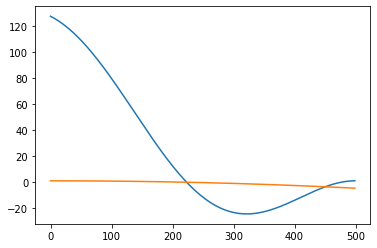

In [60]:
# Calculations at 16 GeV

idx = idx_16
chosen_v = 7 
sigma_t = bunch_time(sigma_e[idx], radiation_turn[idx],radiation_turn[idx] + chosen_v,
                               harmonic[idx], eta[idx], earray_gev[idx]*1e3, rev_f[idx], n_points=500)
    
synch_omega = synchrotron_omega(radiation_turn[idx], radiation_turn[idx] + chosen_v,
                                   harmonic[idx], eta[idx], earray_gev[idx]*1e3, rev_f[idx])

In [61]:
def gaussian(x, x0, delta):
    return 1/(delta*2*np.pi)*np.exp(-0.5*(x-x0)**2/delta**2)

9.225181673902658e-07
9.225181673902658e-07


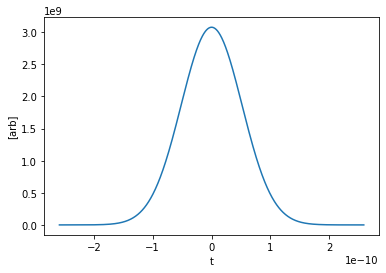

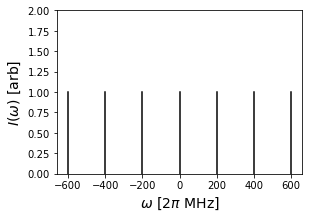

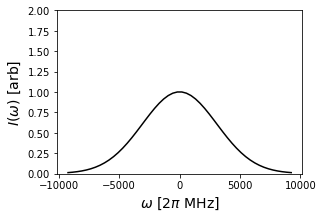

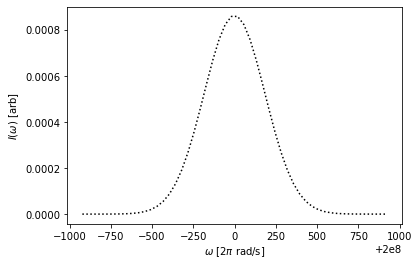

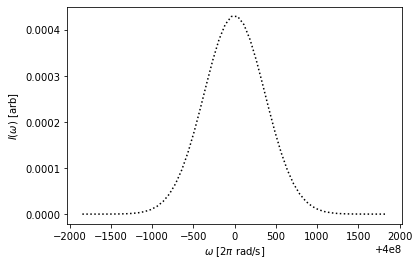

In [62]:
# Assuming 5ns bunch spacing...
idx=idx_16
reduced_harmonic = 1/rev_f[idx]*200e6
tarray_bunch = np.linspace(-5*sigma_t, 5*sigma_t, 1000)
bunch_t = gaussian(tarray_bunch, 0, sigma_t)


omegaarray_bunch = np.linspace(-3/sigma_t, 3/sigma_t)
bunch_omega = gaussian(omegaarray_bunch, 0, 1/sigma_t) 

plt.figure()
plt.plot(tarray_bunch, bunch_t)
plt.xlabel('t')
plt.ylabel('[arb]')

plt.figure(figsize=(4.4, 3))
harmonics = np.arange(-3, 4)
for h in harmonics:
    this_f = h*reduced_harmonic*rev_f[idx]
    plt.axvline(this_f*1e-6, ymin=0, ymax=0.5, color='black')
plt.xlabel(r'$\omega$ [$2\pi$ MHz]', fontsize=14)
plt.ylabel(r'$I(\omega)$ [arb]', fontsize=14)
plt.ylim(0,2)

plt.figure(figsize=(4.4,3))
plt.plot(1e-6*omegaarray_bunch/(2*np.pi), bunch_omega/bunch_omega.max(), color='black')
plt.xlabel(r'$\omega$ [$2\pi$ MHz]', fontsize=14)
plt.ylabel(r'$I(\omega)$ [arb]', fontsize=14)
plt.ylim(0,2)

harmonics = np.arange(1, 3)

for h in harmonics:
    plt.figure()
    this_f = h*reduced_harmonic*rev_f[idx]
    deltaf = np.abs(eta[idx]*sigma_e[idx]*this_f)
    print(eta[idx]*sigma_e[idx])
    fs_tmp = np.linspace(-5*deltaf+this_f, 5*deltaf+this_f)
    dist = gaussian(fs_tmp, this_f, deltaf)
    plt.plot(fs_tmp, dist, color='black', linestyle='dotted')
    plt.xlabel(r'$\omega$ [$2\pi$ rad/s]')
    plt.ylabel(r'$I(\omega)$ [arb]')

(700.0, 3100.0)

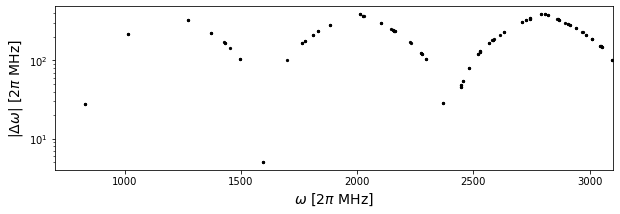

In [131]:
# Plot single cell rf frequencies and distance to closest harmonic

plt.figure(figsize=(10, 3))
harmonics = np.arange(1, 25)*df_freq[0]
hom_distance = [np.min(np.abs(hom-harmonics)) for hom in df_freq.values[1:]]

plt.scatter(df_freq.values[1:], hom_distance,  color='k', s=5, marker='o')
plt.yscale('log')
plt.xlabel(r'$\omega$ [$2\pi$ MHz]', fontsize=14)
plt.ylabel(r'$|\Delta \omega|$ [$2\pi$ MHz]', fontsize=14)
plt.xlim(700, 3100)

In [95]:
qx_dec = qx - int(qx)
delta_qx = np.abs(dqx*sigma_e[idx])


In [99]:
# For CST

total_charge = e*n_electrons
bunch_charge = total_charge/harmonic[0]*4; bunch_charge
wakelength = c/200e6; wakelength

1.49896229

In [104]:
# Approximate frequency from cyllindrical

dome_r = 0.34/2
cell_l = 0.9375/5
f_tm010 = 2.405 * c / (dome_r*2*np.pi)
f_tm011 = np.sqrt((2.405/dome_r)**2 + np.pi**2/cell_l**2)*c/2/np.pi; f_tm011

1046301367.8511301

In [125]:
# Import and plot wakefield impedance curves

imp_x = pd.read_csv('./X_impedance.txt', sep='\s+', skiprows=2, names=['Frequency', 'Wakefield'])
imp_y = pd.read_csv('./Y_impedance.txt', sep='\s+', skiprows=2, names=['Frequency', 'Wakefield'])
imp_z = pd.read_csv('./Z_impedance.txt', sep='\s+', skiprows=2, names=['Frequency', 'Wakefield'])

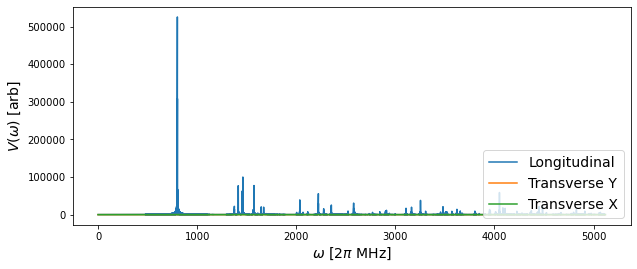

In [130]:
plt.figure(figsize=(10, 4))
plt.plot(imp_x.Frequency, imp_x.Wakefield, label='Longitudinal')
plt.plot(imp_y.Frequency, imp_y.Wakefield, label='Transverse Y')
plt.plot(imp_z.Frequency, imp_z.Wakefield, label='Transverse X')
plt.yscale('linear')
plt.ylabel(r'$V(\omega)$ [arb]', fontsize=14)
plt.xlabel(r'$\omega$ [$2\pi$ MHz]', fontsize=14)
plt.legend(fontsize=14, loc='lower right')

(1300.0, 1500.0)

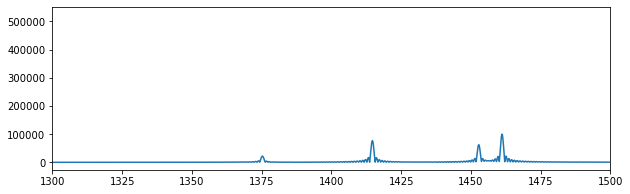

In [116]:
plt.figure(figsize=(10, 3))
plt.plot(imp_x.Frequency, imp_x.Wakefield)
plt.yscale('linear')
plt.xlim(1300, 1500)